In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
import time
import os

# 1. 設定參數 (Configuration)
# ---------------------------------------------------------
DATA_DIR = './data'     
BATCH_SIZE = 16         
NUM_EPOCHS = 20         
NUM_CLASSES = 102       # 改成 102 種花
LEARNING_RATE = 0.01  

# 確保 DEVICE 有被定義
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 2. 資料前處理 (維持原樣)
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), # 花可以多轉一點角度
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. 載入資料 (改用 Flowers102)
# Flowers102 的 split 參數是 'train' 和 'test'
image_datasets = {
    'training': Flowers102(root=DATA_DIR, split='train', download=True, transform=data_transforms['training']),
    'validation': Flowers102(root=DATA_DIR, split='test', download=True, transform=data_transforms['validation'])
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
               for x in ['training', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}

# 4. 建立 ResNet-50 模型
print("Loading ResNet-50 pretrained model...")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_ftrs = model.fc.in_features
# 確保輸出層改為 102
model.fc = nn.Linear(num_ftrs, NUM_CLASSES) 

model = model.to(DEVICE)

# 5. 定義 Loss 和 Optimizer
# ---------------------------------------------------------
criterion = nn.CrossEntropyLoss()
# 使用 SGD 或 AdamW 都可以，這裡用 SGD + Momentum 是經典設定
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# 6. 訓練迴圈 (Training Loop)
# ---------------------------------------------------------
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 每個 epoch 都有訓練和驗證階段
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # 設定為訓練模式
            else:
                model.eval()   # 設定為評估模式

            running_loss = 0.0
            running_corrects = 0

            # 批次讀取資料
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # 統計
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 紀錄最佳模型
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 載入最佳權重
    model.load_state_dict(best_model_wts)
    return model

# 7. 開始訓練並存檔
# ---------------------------------------------------------
model_ft = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

# 儲存 Baseline 模型 (之後比較用)
torch.save(model_ft.state_dict(), 'resnet50_monkey_baseline.pth')
print("Model saved as resnet50_monkey_baseline.pth")

Using device: cuda
Loading ResNet-50 pretrained model...
Epoch 0/19
----------
training Loss: 4.1938 Acc: 0.1392
validation Loss: 2.7839 Acc: 0.4098

Epoch 1/19
----------
training Loss: 1.5751 Acc: 0.6265
validation Loss: 1.1386 Acc: 0.7086

Epoch 2/19
----------
training Loss: 0.4799 Acc: 0.8716
validation Loss: 0.8878 Acc: 0.7712

Epoch 3/19
----------
training Loss: 0.2515 Acc: 0.9304
validation Loss: 0.7210 Acc: 0.8081

Epoch 4/19
----------
training Loss: 0.1390 Acc: 0.9627
validation Loss: 0.5892 Acc: 0.8421

Epoch 5/19
----------
training Loss: 0.0508 Acc: 0.9912
validation Loss: 0.5711 Acc: 0.8527

Epoch 6/19
----------
training Loss: 0.0366 Acc: 0.9941
validation Loss: 0.5822 Acc: 0.8486

Epoch 7/19
----------
training Loss: 0.0404 Acc: 0.9912
validation Loss: 0.4874 Acc: 0.8743

Epoch 8/19
----------
training Loss: 0.0274 Acc: 0.9951
validation Loss: 0.4985 Acc: 0.8728

Epoch 9/19
----------
training Loss: 0.0176 Acc: 0.9990
validation Loss: 0.5349 Acc: 0.8640

Epoch 10/19
-

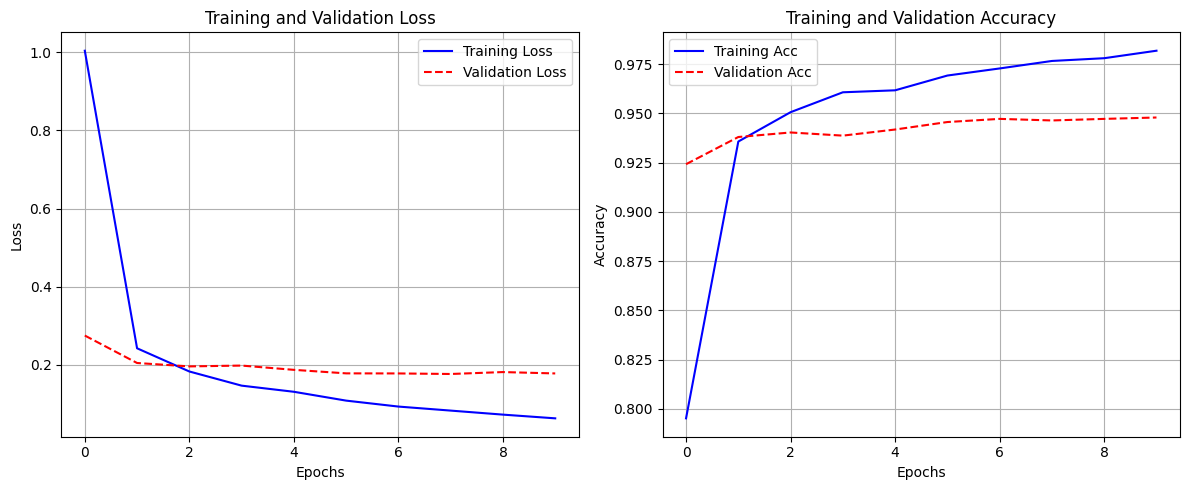

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 填入你剛剛跑出來的數據 (手動填入 Log 裡的數字)
epochs = range(20) # 0 到 19
train_loss = [4.1938, 1.5751, 0.4799, 0.2515, 0.1390, 0.0508, 0.0366, 0.0404, 0.0274, 0.0176, 0.0123, 0.0111, 0.0152, 0.0140, 0.0170, 0.0043, 0.0051, 0.0069, 0.0082, 0.0082]
val_loss   = [2.7839, 1.1386, 0.8878, 0.7210, 0.5892, 0.5711, 0.5822, 0.4874, 0.4985, 0.5349, 0.4636, 0.4745, 0.4317, 0.5057, 0.4645, 0.4811, 0.4767, 0.5014, 0.4764, 0.4649]

train_acc  = [0.1392, 0.6265, 0.8716, 0.9304, 0.9627, 0.9912, 0.9941, 0.9912, 0.9951, 0.9990, 0.9990, 0.9971, 0.9971, 0.9961, 0.9971, 1.0000, 0.9990, 0.9980, 0.9980, 0.9980]
val_acc    = [0.4098, 0.7086, 0.7712, 0.8081, 0.8421, 0.8527, 0.8486, 0.8743, 0.8728, 0.8640, 0.8816, 0.8816, 0.8889, 0.8709, 0.8787, 0.8795, 0.8806, 0.8723, 0.8771, 0.8834]

# 2. 開始畫圖
plt.figure(figsize=(12, 5))

# 左邊畫 Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 右邊畫 Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Acc')
plt.plot(epochs, val_acc, 'r--', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('resnet50_baseline_learning_curve.png') # 存成圖檔
plt.show()